In [1]:
import tensorflow as tf
from tensorflow import keras
import pandas as pd
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
import matplotlib.pyplot as plt

In [2]:
def plot_graphs(history, string):
      plt.plot(history.history[string])
      plt.plot(history.history['val_'+string])
      plt.xlabel("Epochs")
      plt.ylabel(string)
      plt.legend([string, 'val_'+string])
      plt.show()

In [3]:
def get_data(filename):
    category=[]
    subcategory=[]
    questions=[]
    with open(filename, 'r') as f:
        for line in f:
            split_index1 = line.index(":")
            split_index2 = line.index(" ")
            category.append(line[:split_index1])
            subcategory.append(line[split_index1+1:split_index2])
            questions.append(line[(split_index2+1):])
    return category, subcategory, questions

In [4]:
def clean_data(questions):
    stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "while", "with", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
    punctuations = '''!()-[]{};:'"`\,<>./?@#$%^&*_~\n'''
    
    for i in range(0,len(questions)):
        question = questions[i].lower()
#         for word in stopwords:
#             token = " " + word + " "
#             question = question.replace(token, " ")
        no_punct = ''
        for char in question:
            if char not in punctuations:
                no_punct = no_punct + char
        no_punct = no_punct.replace("  ", " ")
        questions[i] = no_punct

In [5]:
def category_predict(ques):
    vocab_size = 7000
    embedding_dim = 256
    max_length = 15
    trunc_type='post'
    padding_type='post'
    oov_tok = "<OOV>"
    
#     train_category = []
#     train_subcategory = []
#     train_questions = []
    
    train_category, train_subcategory, train_questions = get_data('train_5500.label')
    clean_data(train_questions)
    
#     test_category = []
#     test_subcategory = []
#     test_questions = []

    test_category, test_subcategory, test_questions = get_data('TREC_10.label')
    clean_data(test_questions)

    clean_data(ques)
#     print(ques)
    
    tokenizer = Tokenizer(num_words = vocab_size, oov_token = oov_tok)
    tokenizer.fit_on_texts(train_questions)
    word_index = tokenizer.word_index
#     print(word_index)

    train_sequences = tokenizer.texts_to_sequences(train_questions)
    train_padded = pad_sequences(train_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
    
    test_sequences = tokenizer.texts_to_sequences(test_questions)
    test_padded = pad_sequences(test_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
#     print(test_sequences)
    
    ques_sequences = tokenizer.texts_to_sequences(ques)
    ques_padded = pad_sequences(ques_sequences, padding=padding_type, maxlen=max_length, truncating=trunc_type)
    
    category_tokenizer = Tokenizer()
    category_tokenizer.fit_on_texts(train_category)
    category_word_index = category_tokenizer.word_index

    train_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(train_category)), maxlen=1)
    test_category_seq = pad_sequences(np.array(category_tokenizer.texts_to_sequences(test_category)), maxlen=1)
    
    model = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.GRU(64, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(32)),
#         keras.layers.Dense(64, activation = 'relu'),
        keras.layers.Dense(32, activation = 'sigmoid'),
        keras.layers.Dense(7, activation = 'softmax')])

    model.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr=0.002), metrics=['acc'])
    #model.summary()
    
    num_epochs = 10
    history = model.fit(train_padded, train_category_seq, epochs = num_epochs, validation_data=(test_padded, test_category_seq), verbose = 2)

    plot_graphs(history, "acc")
    plot_graphs(history, "loss")
    
    prediction = model.predict(ques_padded)
    print(ques)
    category_predicted=[]
    for i in prediction:
#     x = i.find(max(i))
        x = (np.where(i == np.amax(i)))[0]
    #     print(x)
        for a in category_word_index:
            if category_word_index[a] == x:
                print(a)
                category_predicted.append(x)
                
                
    subcategory_tokenizer = Tokenizer()
    subcategory_tokenizer.fit_on_texts(train_subcategory)
    subcategory_word_index = subcategory_tokenizer.word_index
#     print(subcategory_word_index)

    train_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(train_subcategory)), maxlen=1)
    test_subcategory_seq = pad_sequences(np.array(subcategory_tokenizer.texts_to_sequences(test_subcategory)), maxlen=1)
    
    model1 = keras.Sequential([
        keras.layers.Embedding(vocab_size, embedding_dim, input_length = max_length),
        keras.layers.Dropout(0.2),
        keras.layers.Bidirectional(keras.layers.GRU(96, return_sequences=True)),
        keras.layers.Bidirectional(keras.layers.LSTM(64)),
    #     tf.keras.layers.Dropout(0.2),
    #     tf.keras.layers.GlobalAveragePooling1D(),
    #     tf.keras.layers.Dense(120, activation = 'relu'),
        keras.layers.Dense(64, activation = 'sigmoid'),
        keras.layers.Dense(48, activation = 'softmax')
    ])

    model1.compile(loss = 'sparse_categorical_crossentropy', optimizer = keras.optimizers.Adam(lr=0.002), metrics=['acc'])
#     model1.summary()

    num_epochs = 20
    history1 = model1.fit((train_padded, train_category_seq), train_subcategory_seq, epochs = num_epochs, validation_data=((test_padded, test_category_seq), test_subcategory_seq), verbose = 2)
  
    plot_graphs(history1, "acc")
    plot_graphs(history1, "loss")
    
    sub_prediction = model1.predict((ques_padded, category_predicted))
    print(subcategory_word_index)
    for i in sub_prediction:
        x = (np.where(i == np.amax(i)))[0]
        print(x)
        for a in subcategory_word_index:
            if subcategory_word_index[a] == x:
                print(a)

#     print(validation_subcategory_seq[-10:])
#     print(validation_questions[-10:])

Train on 5452 samples, validate on 500 samples
Epoch 1/10
5452/5452 - 52s - loss: 1.2082 - acc: 0.5429 - val_loss: 0.6231 - val_acc: 0.8160
Epoch 2/10
5452/5452 - 16s - loss: 0.4946 - acc: 0.8586 - val_loss: 0.4609 - val_acc: 0.8480
Epoch 3/10
5452/5452 - 15s - loss: 0.2514 - acc: 0.9351 - val_loss: 0.5431 - val_acc: 0.8480
Epoch 4/10
5452/5452 - 16s - loss: 0.1403 - acc: 0.9674 - val_loss: 0.4774 - val_acc: 0.8740
Epoch 5/10
5452/5452 - 16s - loss: 0.0947 - acc: 0.9773 - val_loss: 0.5934 - val_acc: 0.8600
Epoch 6/10
5452/5452 - 16s - loss: 0.0600 - acc: 0.9883 - val_loss: 0.5164 - val_acc: 0.8720
Epoch 7/10
5452/5452 - 15s - loss: 0.0428 - acc: 0.9906 - val_loss: 0.5576 - val_acc: 0.8680
Epoch 8/10
5452/5452 - 16s - loss: 0.0306 - acc: 0.9936 - val_loss: 0.5720 - val_acc: 0.8620
Epoch 9/10
5452/5452 - 16s - loss: 0.0218 - acc: 0.9954 - val_loss: 0.6246 - val_acc: 0.8640
Epoch 10/10
5452/5452 - 16s - loss: 0.0248 - acc: 0.9939 - val_loss: 0.5736 - val_acc: 0.8780


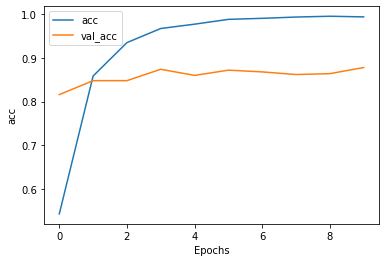

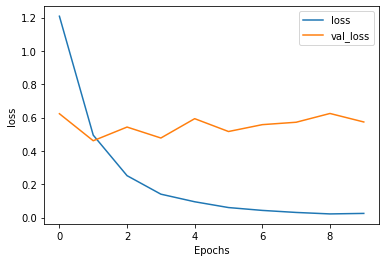

['who was bill gates ', 'where is london located ', 'what is schrodinger s cat ', 'can earth be a planet ', 'how long does it take to dance ']
hum
loc
desc
desc
num
Train on 5452 samples, validate on 500 samples
Epoch 1/20
5452/5452 - 43s - loss: 2.6971 - acc: 0.3144 - val_loss: 2.1162 - val_acc: 0.5520
Epoch 2/20
5452/5452 - 21s - loss: 1.7662 - acc: 0.5614 - val_loss: 1.6945 - val_acc: 0.5960
Epoch 3/20
5452/5452 - 21s - loss: 1.1826 - acc: 0.7082 - val_loss: 1.5127 - val_acc: 0.6400
Epoch 4/20
5452/5452 - 21s - loss: 0.7813 - acc: 0.8226 - val_loss: 1.4218 - val_acc: 0.6940
Epoch 5/20
5452/5452 - 22s - loss: 0.5597 - acc: 0.8646 - val_loss: 1.3815 - val_acc: 0.7180
Epoch 6/20
5452/5452 - 20s - loss: 0.4072 - acc: 0.9057 - val_loss: 1.3338 - val_acc: 0.7260
Epoch 7/20
5452/5452 - 20s - loss: 0.3015 - acc: 0.9288 - val_loss: 1.3292 - val_acc: 0.7320
Epoch 8/20
5452/5452 - 20s - loss: 0.2290 - acc: 0.9485 - val_loss: 1.3656 - val_acc: 0.7540
Epoch 9/20
5452/5452 - 20s - loss: 0.1635 - 

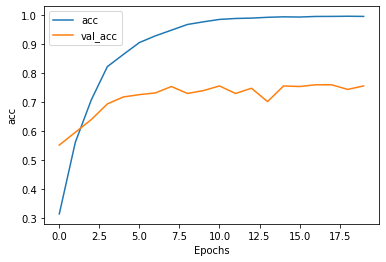

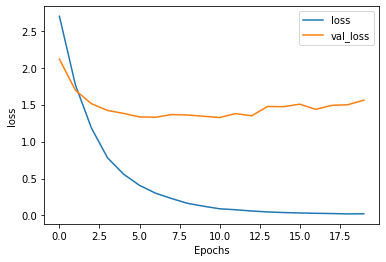

{'ind': 1, 'other': 2, 'def': 3, 'count': 4, 'desc': 5, 'manner': 6, 'date': 7, 'cremat': 8, 'reason': 9, 'gr': 10, 'country': 11, 'city': 12, 'animal': 13, 'food': 14, 'dismed': 15, 'termeq': 16, 'period': 17, 'money': 18, 'exp': 19, 'state': 20, 'sport': 21, 'event': 22, 'product': 23, 'substance': 24, 'color': 25, 'techmeth': 26, 'dist': 27, 'perc': 28, 'veh': 29, 'word': 30, 'title': 31, 'mount': 32, 'body': 33, 'abb': 34, 'lang': 35, 'plant': 36, 'volsize': 37, 'symbol': 38, 'weight': 39, 'instru': 40, 'letter': 41, 'speed': 42, 'code': 43, 'temp': 44, 'ord': 45, 'religion': 46, 'currency': 47}
[5]
desc
[2]
other
[3]
def
[3]
def
[17]
period


In [6]:
category_predict(["Who was Bill Gates ?", "Where is London located ?", "What is Schrodinger 's cat ?", "Can earth be a planet ?", "How long does it take to dance ?"])

In [ ]:
category_predict(["Who was Bill Gates ?", "Where is Mumbai located ?", "What is Schrodinger 's cat ?", "Can earth be a planet ?", "How long does it take to dance ?"])

Train on 5452 samples, validate on 500 samples
Epoch 1/10
5452/5452 - 43s - loss: 1.0898 - acc: 0.6088 - val_loss: 0.6283 - val_acc: 0.8140
Epoch 2/10
5452/5452 - 15s - loss: 0.3662 - acc: 0.8971 - val_loss: 0.4771 - val_acc: 0.8480
Epoch 3/10
5452/5452 - 16s - loss: 0.1760 - acc: 0.9551 - val_loss: 0.4579 - val_acc: 0.8640
Epoch 4/10
5452/5452 - 16s - loss: 0.1060 - acc: 0.9747 - val_loss: 0.5177 - val_acc: 0.8580
Epoch 5/10
5452/5452 - 16s - loss: 0.0551 - acc: 0.9884 - val_loss: 0.5056 - val_acc: 0.8820
Epoch 6/10
5452/5452 - 16s - loss: 0.0384 - acc: 0.9927 - val_loss: 0.5834 - val_acc: 0.8720
Epoch 7/10
5452/5452 - 17s - loss: 0.0287 - acc: 0.9938 - val_loss: 0.5723 - val_acc: 0.8800
Epoch 8/10


In [19]:
stopwords = [ "a", "about", "above", "after", "again", "against", "all", "am", "an", "and", "any", "are", "as", "at", "be", "because", "been", "before", "being", "below", "between", "both", "but", "by", "could", "did", "do", "does", "doing", "down", "during", "each", "few", "for", "from", "further", "had", "has", "have", "having", "he", "he'd", "he'll", "he's", "her", "here", "here's", "hers", "herself", "him", "himself", "his", "i", "i'd", "i'll", "i'm", "i've", "if", "in", "into", "is", "it", "it's", "its", "itself", "let's", "me", "more", "most", "my", "myself", "nor", "of", "on", "once", "only", "or", "other", "ought", "our", "ours", "ourselves", "out", "over", "own", "same", "she", "she'd", "she'll", "she's", "should", "so", "some", "such", "than", "that", "that's", "the", "their", "theirs", "them", "themselves", "then", "there", "there's", "these", "they", "they'd", "they'll", "they're", "they've", "this", "those", "through", "to", "too", "under", "until", "up", "very", "was", "we", "we'd", "we'll", "we're", "we've", "were", "while", "with", "you", "you'd", "you'll", "you're", "you've", "your", "yours", "yourself", "yourselves"]
len(stopwords)

138